In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import pandas_datareader as web
from sklearn.linear_model import LinearRegression


In [2]:
# Các hàm định nghĩa
# Dinh nghia ham ACF va PACF
def sACF(y,K):
    T = len(y)
    ytb = y.mean()
    ACF = np.zeros(K)
    c0 = np.sum((y-ytb)**2)/T
    for k in range(1, K+1):
        ck = np.sum((y-ytb)[:T-k]*(y-ytb)[k:T])/T
        ACF[k-1]= ck/c0
    
    se_ACF = np.zeros(K)
    for i in range(K):
        se_ACF[i] = np.sqrt(1/T*(1+2*np.sum(ACF[:i]**2)))
    return ACF, se_ACF

def sPACF(y,K):
    T = len(y)
    #Lay day dau tien
    ACF = sACF(y,K)[0]
    PACF = np.zeros(K)
    for m in range(1,K+1):
        P = np.eye(m)
        for i in range(m):
            for j in range(i):
                P[i,j] = ACF[i-j-1]
            for j in range(i+1,m):
                P[i,j] = ACF[j-i-1];
        PACF[m-1] = np.linalg.solve(P,ACF[:m])[-1]
    se_PACF = np.array([1/np.sqrt(T) for i in range(K)])
    return PACF, se_PACF

# Tính thống kê Q(k)
def Qstat(at,k):
    at_ACF = sACF(at,k)[0]
    n = len(at)
    Qstat = 0
    for i in range(k):
        Qstat += n*(n+2)*at_ACF[i]**2/(n-i-1)
    return Qstat

### Bài tập 5.2

In [3]:
data = pd.read_excel('bai tap/5.2.xlsx')
data.head()

,Period,yt
0,1,29
1,2,20
2,3,25
3,4,29
4,5,31


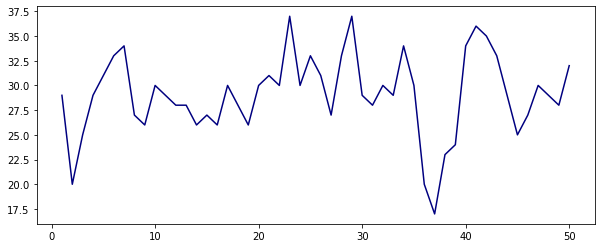

In [4]:
fig, ax = plt.subplots(figsize = (10,4))
ax.plot(data['Period'], data['yt'], color='navy')
plt.show()

In [5]:
# Thống kê mô tả cơ bản
y = data['yt'].values
n = len(y)
#tb
ytb = y.mean()
#độ lệch chuẩn
s_y = y.std()
print("Gía trị trung bình: ", ytb)
print("Độ lệch chuẩn:" , s_y)

Gía trị trung bình:  29.06
Độ lệch chuẩn: 4.091014544095389


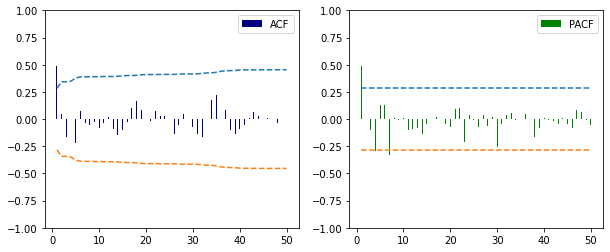

In [6]:
# TÍnh và vẽ biểu đồ tương quan ACF và PACF
K = 50
ACF, se_ACF = sACF(y,K)
PACF, se_PACF = sPACF(y,K)

fig, ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1, K+1)
ax[0].bar(x,ACF, color='navy', width= 0.2 , label="ACF")
ax[0].plot(x, 2*se_ACF, linestyle='dashed')
ax[0].plot(x,-2*se_ACF, linestyle='dashed')
ax[0].set_ylim([-1,1])
ax[0].legend()

ax[1].bar(x,PACF, color='green', width= 0.2 , label="PACF")
ax[1].plot(x, 2*se_PACF, linestyle='dashed')
ax[1].plot(x,-2*se_PACF, linestyle='dashed')
ax[1].set_ylim([-1,1])
ax[1].legend()

plt.show()

nhận xét: PACF sau độ trễ k = 1 có giá trị xấp xỉ 0

In [7]:
# Ước lượng tham số mô hình AR(1): y_t = \theta_0 + \phi y(t-1) + a(t)
model = LinearRegression(fit_intercept = False)
ydata = y[1:]
n = len(ydata)
X = np.vstack([np.ones(n), y[:-1]]).T
model.fit(X,ydata)

#Sai số tiêu chuẩn của ước lượng tham số mô hình
at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-2))
se_param = sigma*np.sqrt(np.diag(np.linalg.inv(X.T@X)))
print('sigma = ', sigma)
                
# Hiển thị dạng bảng
df = pd.DataFrame(np.vstack([model.coef_, se_param]).T,
                 columns=['parameter', 'se(parameter)'])
df

sigma =  3.6864285329554973


,parameter,se(parameter)
0,14.876442,3.752394
1,0.489130,0.128112


In [8]:
 #Tính thống kê Dicker-Fuller
t_m = (df['parameter'][1]-1)/df['se(parameter)'][1]
print("giá trị thống kê ADF", t_m)

giá trị thống kê ADF -3.9876715524546458


In [9]:
dy = y

In [10]:
# Xây dựng mô hình
model = LinearRegression(fit_intercept = False)
ydata = dy[1:]
X = dy[:-1].reshape(-1,1)
model.fit(X, ydata)
phi = model.coef_[0]
print("Phi= ",phi)
print(f'Mô hình có dạng: dy(t) = {model.coef_[0]} dy(t-1)+ a(t)')

at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(ydata-1)))
print("sigma=", sigma)

Phi=  0.9920070414158959
Mô hình có dạng: dy(t) = 0.9920070414158959 dy(t-1)+ a(t)
sigma= 4.170631934488381


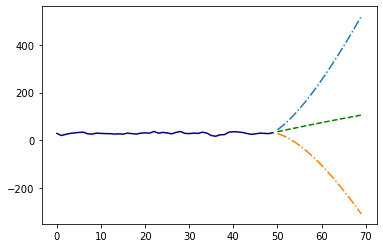

In [11]:
phi1 = 1 + phi
# Xác định giá trị dự báo
h = 20 # thời hạn dự báo
y_forecast = np.zeros(h)
y_forecast[0] = phi1*y[-1] - phi*y[-2]
y_forecast[1] = phi1*y_forecast[0] - phi*y[-1]

for i in range(2,h):
    y_forecast[i]= phi1*y_forecast[i-1] - phi*y_forecast[i-2]

# Tìm trọng số psi trong biểu diễn MA(infinity)
psi = np.zeros(h)
psi[0] = 1
psi[1] = phi1
for i in range(2,h):
    psi[i] = phi1*psi[i-1] - phi*psi[i-2]
    
# Độ lệch tiêu chuẩn của sai số dự báo
sigma_h = sigma*np.array([np.sqrt(np.sum(psi[:j]**2)) for j in range(1,h+1)])
z = 1.96 # Phân vị chuẩn ở mức xác suất alpha = 5%
UCL = y_forecast + z*sigma_h #Upper confidence limit
LCL = y_forecast - z*sigma_h #Lower confidence limit    

 #  Ve do thi
T = len(y)
x_past = np.arange(T)
x_future = np.arange(h) + T
x = np.concatenate([x_past, x_future])
plt.plot(x_past, y, color='navy')
plt.plot(x_future, y_forecast, color='green', linestyle='dashed')
plt.plot(x_future, UCL, linestyle='dashdot')
plt.plot(x_future, LCL, linestyle='dashdot')

# Bài tập 5.3



In [12]:
data2 = pd.read_excel('bai tap/5.3.xlsx')
data2.head()

,Period,yt
0,1,500
1,2,496
2,3,450
3,4,448
4,5,456


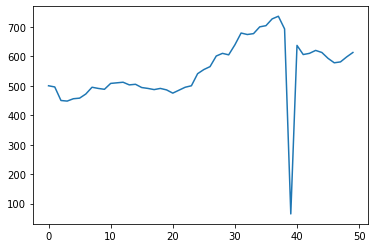

In [13]:
y = data2['yt'].values
plt.plot(y)

In [14]:
# Thống kê mô tả cơ bản
n = len(y)
#tb
ytb = y.mean()
#độ lệch chuẩn
s_y = y.std()
print("Gía trị trung bình: ", ytb)
print("Độ lệch chuẩn:" , s_y)

Gía trị trung bình:  550.32
Độ lệch chuẩn: 106.64041260235258


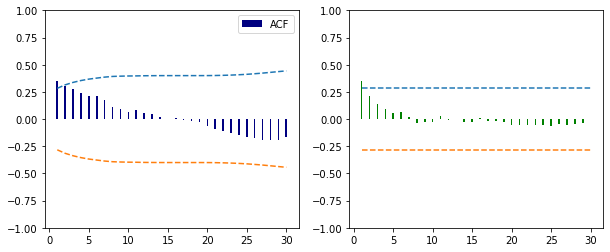

In [15]:
# TÍnh và vẽ biểu đồ tương quan ACF và PACF
K = 30
ACF, se_ACF = sACF(y,K)
PACF, se_PACF = sPACF(y,K)

fig, ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1, K+1)
ax[0].bar(x,ACF, color='navy', width= 0.2 , label="ACF")
ax[0].plot(x, 2*se_ACF, linestyle='dashed')
ax[0].plot(x,-2*se_ACF, linestyle='dashed')
ax[0].set_ylim([-1,1])
ax[0].legend()

ax[1].bar(x,PACF, color='green', width= 0.2 , label="PACF")
ax[1].plot(x, 2*se_PACF, linestyle='dashed')
ax[1].plot(x,-2*se_PACF, linestyle='dashed')
ax[1].set_ylim([-1,1])
ax[0].legend()

plt.show()

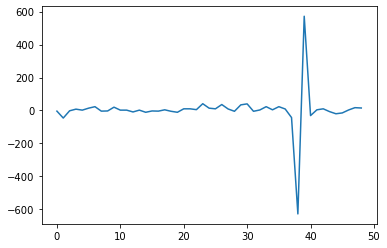

In [16]:
# Tính sai phân
dy = np.diff(y)
dy.mean()
plt.plot(dy)
plt.show()

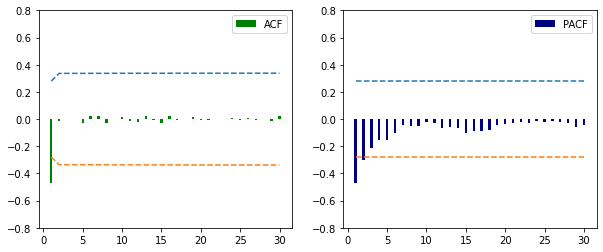

In [22]:
ACF, se_ACF = sACF(dy,K)
PACF, se_PACF = sPACF(dy,K)


# Vẽ đồ thị
fig,ax = plt.subplots(1,2,figsize = (10,4))
x = np.arange(1,K+1)
ax[0].bar(x, ACF, color='green', width = 0.3, label='ACF')
ax[0].plot(x, 1.96*se_ACF, linestyle='dashed')
ax[0].plot(x, -1.96*se_ACF, linestyle='dashed')
ax[0].set_ylim([-0.8, 0.8])
ax[0].legend()

ax[1].bar(x, PACF, color='navy', width = 0.3, label='PACF')
ax[1].plot(x, 1.96*se_PACF, linestyle='dashed')
ax[1].plot(x, -1.96*se_PACF, linestyle='dashed')
ax[1].set_ylim([-0.8, 0.8])
ax[1].legend()
plt.show()

In [23]:
# Ước lượng tham số mô hình AR(1): y_t = \theta_0 + \phi y(t-1) + a(t)
model = LinearRegression(fit_intercept = False)
ydata = y[1:]
n = len(ydata)
X = np.vstack([np.ones(n), y[:-1]]).T
model.fit(X,ydata)

#Sai số tiêu chuẩn của ước lượng tham số mô hình
at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(at)-2))
se_param = sigma*np.sqrt(np.diag(np.linalg.inv(X.T@X)))
print('sigma = ', sigma)
                
# Hiển thị dạng bảng
df = pd.DataFrame(np.vstack([model.coef_, se_param]).T,
                 columns=['parameter', 'se(parameter)'])
df

sigma =  102.86596270271838


,parameter,se(parameter)
0,359.829002,76.586362
1,0.348823,0.136899


In [24]:
 #Tính thống kê Dicker-Fuller
t_m = (df['parameter'][1]-1)/df['se(parameter)'][1]
print("giá trị thống kê ADF", t_m)

giá trị thống kê ADF -4.756614091735868


Nhận xét: Sau khi lấy sai phân thì ta có chuỗi dừng


In [18]:
# Xây dựng mô hình
model = LinearRegression(fit_intercept = False)
ydata = dy[1:]
X = dy[:-1].reshape(-1,1)
model.fit(X, ydata)
phi = model.coef_[0]
print("Phi= ",phi)
print(f'Mô hình có dạng: dy(t) = {model.coef_[0]} dy(t-1)+ a(t)')

at = ydata - model.predict(X)
sigma = np.sqrt(np.sum(at**2)/(len(ydata-1)))
print("sigma=", sigma)

Phi=  -0.46990919825725813
Mô hình có dạng: dy(t) = -0.46990919825725813 dy(t-1)+ a(t)
sigma= 109.38172711934905


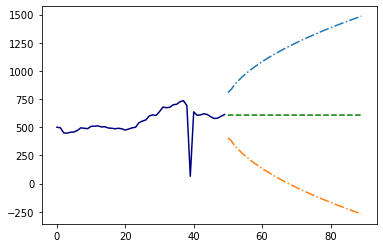

In [25]:
phi1 = 1 + phi
# Xác định giá trị dự báo
h = 40# thời hạn dự báo
y_forecast = np.zeros(h)
y_forecast[0] = phi1*y[-1] - phi*y[-2]
y_forecast[1] = phi1*y_forecast[0] - phi*y[-1]

for i in range(2,h):
    y_forecast[i]= phi1*y_forecast[i-1] - phi*y_forecast[i-2]

# Tìm trọng số psi trong biểu diễn MA(infinity)
psi = np.zeros(h)
psi[0] = 1
psi[1] = phi1
for i in range(2,h):
    psi[i] = phi1*psi[i-1] - phi*psi[i-2]
    
# Độ lệch tiêu chuẩn của sai số dự báo
sigma_h = sigma*np.array([np.sqrt(np.sum(psi[:j]**2)) for j in range(1,h+1)])
z = 1.96 # Phân vị chuẩn ở mức xác suất alpha = 5%
UCL = y_forecast + z*sigma_h #Upper confidence limit
LCL = y_forecast - z*sigma_h #Lower confidence limit    

 #  Ve do thi
T = len(y)
x_past = np.arange(T)
x_future = np.arange(h) + T
x = np.concatenate([x_past, x_future])
plt.plot(x_past, y, color='navy')
plt.plot(x_future, y_forecast, color='green', linestyle='dashed')
plt.plot(x_future, UCL, linestyle='dashdot')
plt.plot(x_future, LCL, linestyle='dashdot')